# K-Means Clustering

Tomado y adaptado de [Pluralsight](https://www.pluralsight.com/courses/building-clustering-models-scikit-learn)

El dataset que se va a utilizar contiene cuatro características (longitud y ancho de sépalos y pétalos) de 50 muestras de tres especies de flores Iris (Iris setosa, Iris virginica e Iris versicolor).

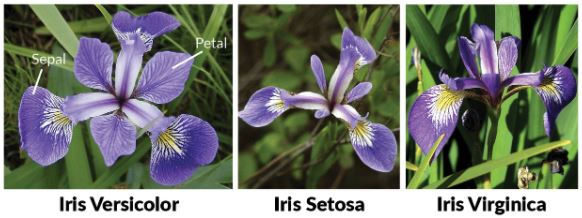

Importamos librerías necesarias.

In [2]:
import matplotlib
import numpy as np
import pandas as pd
import seaborn as sb
from tabulate import tabulate 
import matplotlib.pyplot as plt
from sklearn import preprocessing
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from sklearn.metrics import pairwise_distances_argmin_min

%matplotlib inline
from mpl_toolkits.mplot3d import Axes3D
plt.rcParams['figure.figsize'] = (25, 12)
plt.style.use('ggplot')

Cargamos el dataset

In [3]:
from google.colab import files
import io

uploaded = files.upload()
iris_df = pd.read_csv(io.BytesIO(uploaded["iris.csv"]))

iris_df.head()

Saving iris.csv to iris (1).csv


,sepal-length,sepal-width,petal-length,petal-width,class
0,5.1,3.5,1.4,0.2,Iris-setosa
1,4.9,3.0,1.4,0.2,Iris-setosa
2,4.7,3.2,1.3,0.2,Iris-setosa
3,4.6,3.1,1.5,0.2,Iris-setosa
4,5.0,3.6,1.4,0.2,Iris-setosa


In [6]:
iris_df.tail()

,sepal-length,sepal-width,petal-length,petal-width,class
145,6.7,3.0,5.2,2.3,Iris-virginica
146,6.3,2.5,5.0,1.9,Iris-virginica
147,6.5,3.0,5.2,2.0,Iris-virginica
148,6.2,3.4,5.4,2.3,Iris-virginica
149,5.9,3.0,5.1,1.8,Iris-virginica


con el atributo `.shape` vemos que el conjunto de datos está compuesto por 150 registros correspondientes a 150 flores particulares con sus respectivas medidas.

Cada registro tiene 5 columnas, las 4 características y la correspondiente a la clase (especie). Normalmente para este tipo de problemas no disponemos de las etiquetas y por eso se usa una tecnica a aprendizaje no supervisado como lo es el clustering.

In [7]:
iris_df.shape

(150, 5)

Si invocamos la funcion `.unique()` en una columna particular obtendremos las etiquetas únicas presentes en el conjunto de datos.

In [8]:
iris_df['class'].unique()

array(['Iris-setosa', 'Iris-versicolor', 'Iris-virginica'], dtype=object)

Contando la cantidad de datos en cada clase vemos que los datos estan perfectamente balanceados, con la misma cantidad de observaciones para cada especie, haciendo que este conjunto de datos (incluyendo las etiquetas) sea un candidato perfecto para trabajar con árboles de clasificación.

In [9]:
print(iris_df.groupby('class').size())

class
Iris-setosa        50
Iris-versicolor    50
Iris-virginica     50
dtype: int64


Ahora vamos a visualizar las 4 características y la especie en un único grafico 3D.

* sepal length en el eje x
* petal length en el eje y
* petal width en el eje z
* especie con diferentes colores
* el tamaño de los puntos es proporcional a sepal width

En este gráfico se puede hacer zoom y también se puede rotar usando el mouse.

In [10]:
import plotly.express as px
import plotly.graph_objects as go

fig = px.scatter_3d(iris_df, x="sepal-length", y="petal-length", z="petal-width", 
                    color="class",size='sepal-width')
fig.show()

Teniendo en cuenta que esta técnica solo sirve para datos numéricos, debemos convertir los valores categóricos como las cadenas de caracteres en números. Esto lo podemos hacer usando `LabelEncoder()` de scikit learn; así se asignarán etiquetas numéricas a cada especie (empezando desde cero).

In [12]:
label_encoding = preprocessing.LabelEncoder()
iris_df['class'] = label_encoding.fit_transform(iris_df['class'].astype(str))
iris_df.head()

,sepal-length,sepal-width,petal-length,petal-width,class
0,5.1,3.5,1.4,0.2,0
1,4.9,3.0,1.4,0.2,0
2,4.7,3.2,1.3,0.2,0
3,4.6,3.1,1.5,0.2,0
4,5.0,3.6,1.4,0.2,0


In [13]:
iris_df.tail()

,sepal-length,sepal-width,petal-length,petal-width,class
145,6.7,3.0,5.2,2.3,2
146,6.3,2.5,5.0,1.9,2
147,6.5,3.0,5.2,2.0,2
148,6.2,3.4,5.4,2.3,2
149,5.9,3.0,5.1,1.8,2


Se ha hecho la siguiente asignación de etiquetas:

0: Setosa

1: Versicolor

2: Virginica

Se puede observar que las muestras están ordenadas por especie. A continuación, vamos a mezclarlas para visualizar mejor el contenido generando nuevos indices.

In [14]:
iris_df = iris_df.sample(frac=1).reset_index(drop=True)
iris_df.head()

,sepal-length,sepal-width,petal-length,petal-width,class
0,6.5,2.8,4.6,1.5,1
1,6.4,2.8,5.6,2.1,2
2,4.3,3.0,1.1,0.1,0
3,5.7,2.9,4.2,1.3,1
4,6.0,2.9,4.5,1.5,1


Por último podemos hacer un resumen estadístico de los datos antes de continuar con la visualización. Excluimos las clases porque son valores categóricos y no tiene mucho sentido en este caso aplicarle esta operación.

In [15]:
iris_df.describe().drop('class', axis=1)

,sepal-length,sepal-width,petal-length,petal-width
count,150.000000,150.000000,150.000000,150.000000
mean,5.843333,3.054000,3.758667,1.198667
std,0.828066,0.433594,1.764420,0.763161
min,4.300000,2.000000,1.000000,0.100000
25%,5.100000,2.800000,1.600000,0.300000
50%,5.800000,3.000000,4.350000,1.300000
75%,6.400000,3.300000,5.100000,1.800000
max,7.900000,4.400000,6.900000,2.500000


## Visualizando los datos

Podemos usar una matriz de dispersión para ver cómo se relacionan los datos.

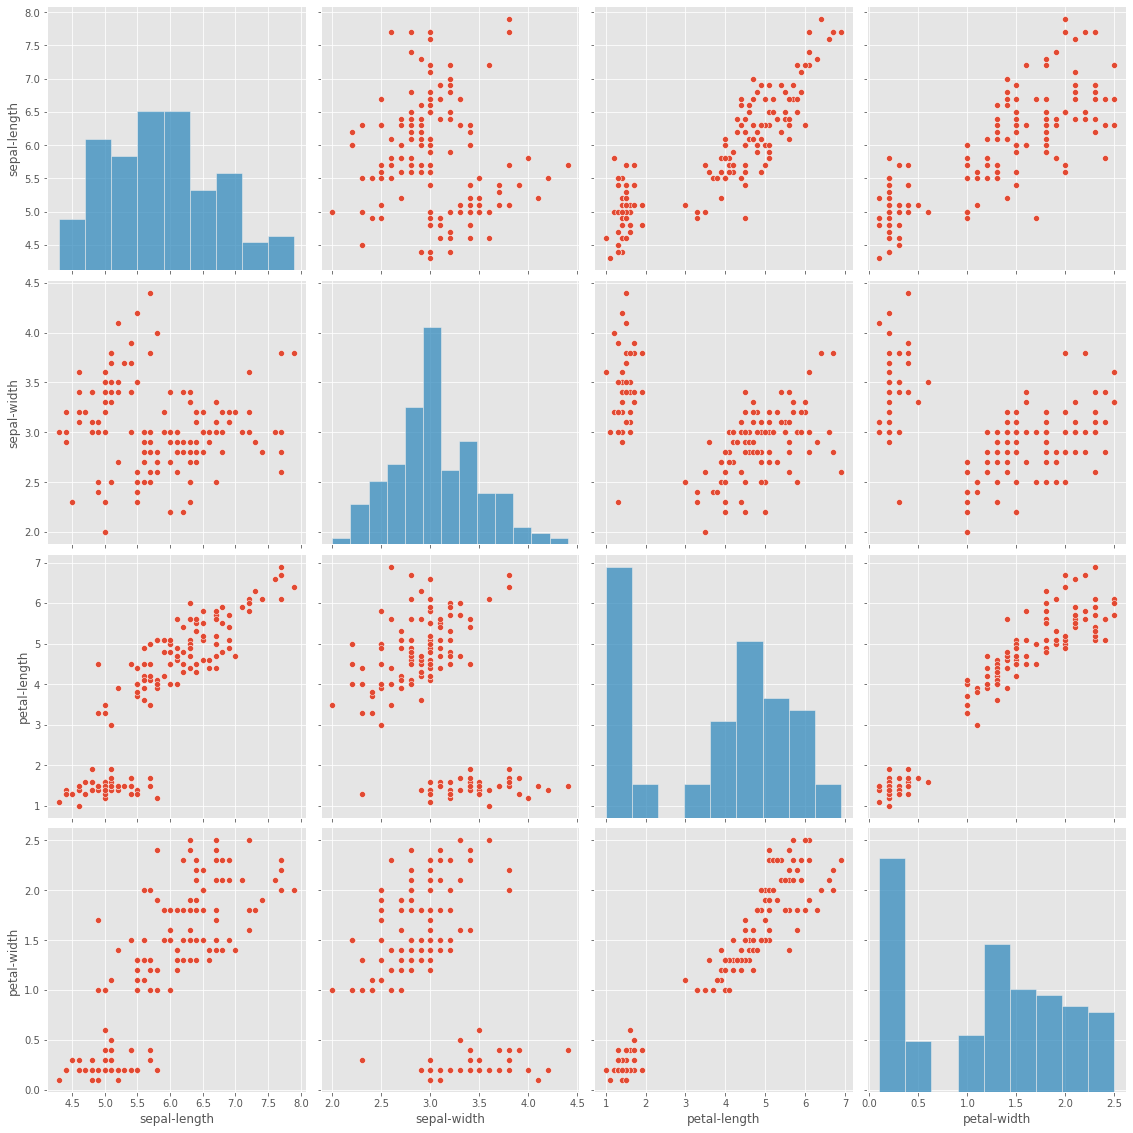

In [16]:
sb.pairplot(iris_df.dropna(),
            height=4, 
            vars=["sepal-length", "sepal-width", "petal-length", "petal-width"],
            kind='scatter')
plt.show()

Vamos a analizar algunos de estos gráficos por separado.

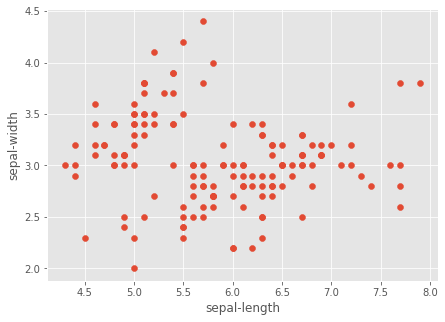

In [17]:
fig = plt.subplots(figsize=(7, 5))

plt.scatter(iris_df['sepal-length'], iris_df['sepal-width'])

plt.xlabel('sepal-length')
plt.ylabel('sepal-width')

plt.show()

Viendo el diagrama del ancho del sépalo vs su longitud puede que no sea tan sencillo encontrar relaciones obvias a simple vista para el agrupamiento.

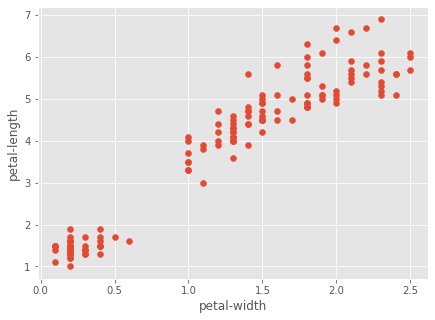

In [18]:
fig = plt.subplots(figsize=(7, 5))

plt.scatter(iris_df['petal-width'], iris_df['petal-length'])

plt.xlabel('petal-width')
plt.ylabel('petal-length')

plt.show()

Por otro lado con las medidas del pétalo podemos ver que hay algunas flores bastante pequeñas (longitudes de pétalos pequeñas y anchos de pétalos pequeños) y otras notoriamente mas grandes.

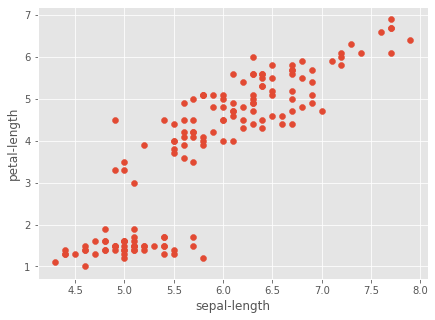

In [19]:
fig = plt.subplots(figsize=(7, 5))

plt.scatter(iris_df['sepal-length'], iris_df['petal-length'])

plt.xlabel('sepal-length')
plt.ylabel('petal-length')

plt.show()

En este caso tal vez podamos diferenciar un poco mejor los grupos.

## Clustering con 2 características

Seleccionamos dos características para el agrupamiento. ('sepal-length' y 'petal-length' que mostraron una division mas marcada)

In [21]:
iris_2D = iris_df[['sepal-length', 'petal-length']]
iris_2D.sample(10)

,sepal-length,petal-length
14,4.9,4.5
97,4.8,1.4
140,5.7,4.2
4,6.0,4.5
44,5.0,1.6
41,7.7,6.7
148,6.1,4.0
9,5.0,1.6
100,4.5,1.3
95,5.9,4.8


In [22]:
iris_2D.shape

(150, 2)

convertimos a un arreglo de numpy.

In [23]:
iris_2D = np.array(iris_2D)

Creamos una instancia de k-means para 3 clusters y la ajustamos a los datos. Elegimos 3 clusters porque sabemos que hay tres especies de flores diferentes. Mas adelante veremos algunos metodos que nos pueden ayudar a elegir el valor de K cuando no tenemos conocimiento previo sobre la casificación del dataset.

In [24]:
kmeans_model_2D = KMeans(n_clusters=3, max_iter=1000).fit(iris_2D)

Una vez hecho el ajuste se asignan etiquetas a cada punto o vector (sepal-length, petal-length) según el cluster al que pertenezca.
Estas etiquetas se asignan de forma aleatoria representando los clusters y pueden no coincidir con las etiquetas de clase iniciales.

In [25]:
labels_2D = kmeans_model_2D.labels_
print(labels_2D)

[2 0 1 2 2 2 2 1 1 1 2 1 2 2 2 1 0 1 1 1 0 2 2 2 2 0 0 0 0 0 2 1 2 2 0 0 1
 0 2 1 1 0 2 1 1 0 2 1 1 2 1 0 1 2 2 1 2 2 2 2 2 1 0 2 0 1 2 1 0 1 1 2 2 1
 2 1 0 0 1 0 1 2 1 0 2 1 2 1 0 2 0 0 0 0 2 2 2 1 1 0 1 2 0 0 1 0 2 0 0 1 1
 1 2 0 0 0 2 1 0 2 1 2 0 2 1 0 1 2 2 1 1 2 1 2 2 1 2 2 0 1 2 2 1 0 1 1 0 2
 2 2]


A continuación visualizamos los centroides de los tres grupos.

In [26]:
centroids_2D = kmeans_model_2D.cluster_centers_
centroids_2D

array([[6.83902439, 5.67804878],
       [5.00784314, 1.49411765],
       [5.87413793, 4.39310345]])

Vamos a graficar los centroides con su correspondiente etiqueta.

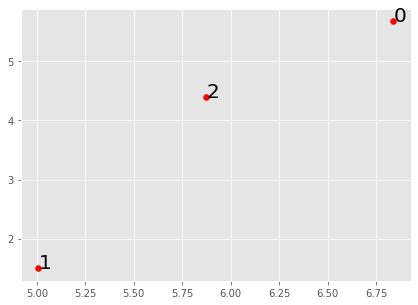

In [27]:
fig, ax = plt.subplots(figsize=(7, 5))

plt.scatter(centroids_2D[:,0], centroids_2D[:,1], c='r', marker='o')

for i in range(len(centroids_2D)):
    plt.annotate(i, (centroids_2D[i][0], centroids_2D[i][1]), fontsize=20)

Vamos a visualizar las categorías de flores del dataset original y los centroides encontrados, todo en un solo gráfico de dispersión, usando colores para cada categoría de flores.

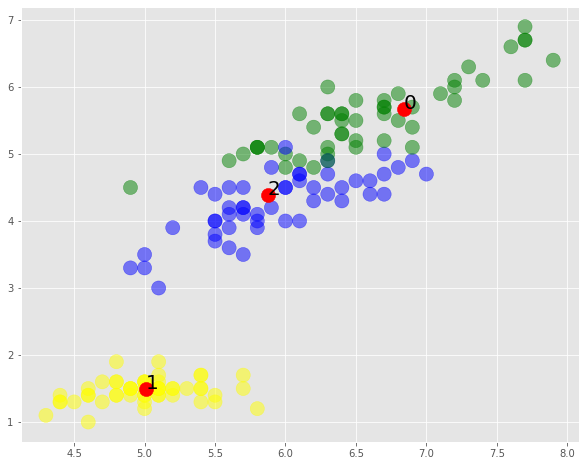

In [28]:
colors_original = ['yellow','blue','green']

plt.figure(figsize=(10, 8))

plt.scatter(iris_df['sepal-length'], iris_df['petal-length'], c=iris_df['class'], s=200,
            cmap=matplotlib.colors.ListedColormap(colors_original), alpha=0.5)

plt.scatter(centroids_2D[:,0], centroids_2D[:,1], c='r', s=200, marker='o')

for i in range(len(centroids_2D)):
    plt.annotate( i, (centroids_2D[i][0], centroids_2D[i][1]), fontsize=20)

Ahora hacemos lo mismo pero asignando los colores según la clasificación hecha por k-means.

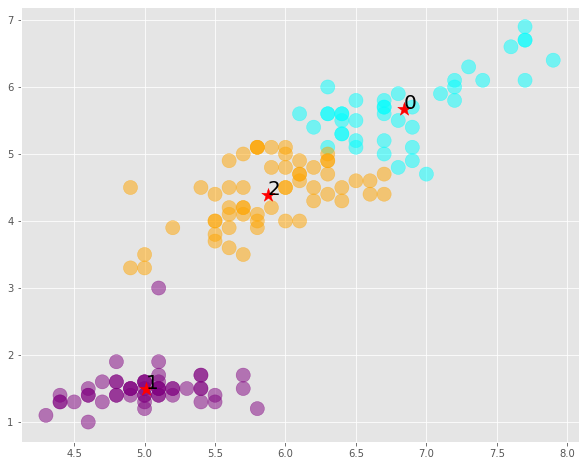

In [29]:
colors_k_means = ['cyan','purple','orange']
 
fig = plt.figure(figsize=(10, 8))
plt.scatter(iris_2D[:, 0], iris_2D[:, 1], c=labels_2D, s=200,
            cmap=matplotlib.colors.ListedColormap(colors_k_means), alpha=0.5)
plt.scatter(centroids_2D[:, 0], centroids_2D[:, 1], c='r', s=200, marker='*')

for i in range(len(centroids_2D)):
    plt.annotate( i, (centroids_2D[i][0], centroids_2D[i][1]), fontsize=20)

Al comparar los dos graficos podemos observar que algunas especies se clasificaron de forma incorrecta. Esto por lo general se debe a datos atípicos. Además es muy recomendado normalizar los datos antes de usar este método de clustering.

## Usando 3 Características y suponiendo que no sabemos que hay 3 clusters

En este caso vamos a usar las dos características anteriores y una mas, por ejemplo el ancho del sépalo. Además, intentaremos hallar la cantidad óptima de clusters usando el metodo de la curva de codo, el estadístico de gap y el coeficiente de silueta.

In [30]:
iris_3D = np.array(iris_df[['sepal-length', 'petal-length', 'sepal-width']])
iris_3D_labels = np.array(iris_df['class'])
print(iris_3D.shape)

(150, 3)


Graficamos las tres características escogidas en un plano 3D para visualizar los datos.

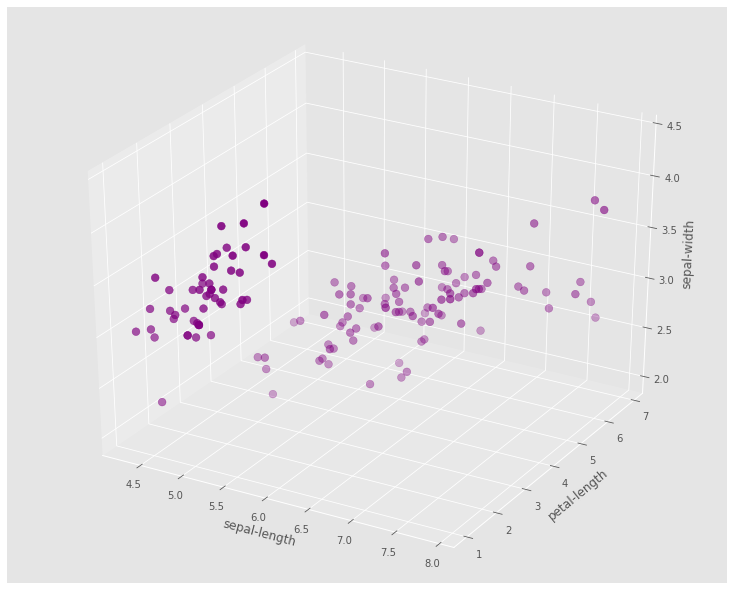

In [31]:
fig = plt.figure(figsize=(10, 8))
ax = Axes3D(fig)
ax.scatter(iris_3D[:, 0], iris_3D[:, 1], iris_3D[:, 2], c='purple', s=60)
ax.set_xlabel('sepal-length')
ax.set_ylabel('petal-length')
ax.set_zlabel('sepal-width')
plt.show()

Ahora vamos a ver diferentes metodos para tratar de encontrar la cantidad optima de clusters.

### Elbow Curve

`inertia_`: Suma de las distancias cuadráticas de las muestras al centro del cluster mas cercano.

Este método usa la inercia como una medida de la variación intra-cluster e intenta minimizarla. Se debe tener en cuenta que la inercia óptima (mínima) sería cero, para el caso donde cada observación es su propio cluster; pero como esto no es de mucha utilidad, el métod del codo escoge como óptimo aquel valor del número de clusters a partir del cual añadir mas clusters solo consigue una mejora mínima de la inercia.

In [32]:
# se define la cantidad de clusters con los que se quiere probar
maxClusters = 10

In [33]:
def elbow_curve(data, maxClusters = 15):

  # rango de valores del parámetro a optimizar (cantidad de clusters)
  maxClusters = range(1, maxClusters + 1)
  inertias = []

  # se ejecuta el modelo para el rango de clusters y se guarda la inercia
  # respectiva obtenida para cada valor
  for k in maxClusters:
    kmeanModel = KMeans(n_clusters = k)
    kmeanModel.fit(iris_3D)
    inertias.append(kmeanModel.inertia_)

  # Grafico de los resultados obtenidos para cada valor del rango
  plt.figure(figsize=(10, 8))
  plt.plot(maxClusters, inertias, 'bx-')
  plt.xlabel('k')
  plt.ylabel('Inertia')
  plt.title('The Elbow Method showing the optimal k')
  plt.show()

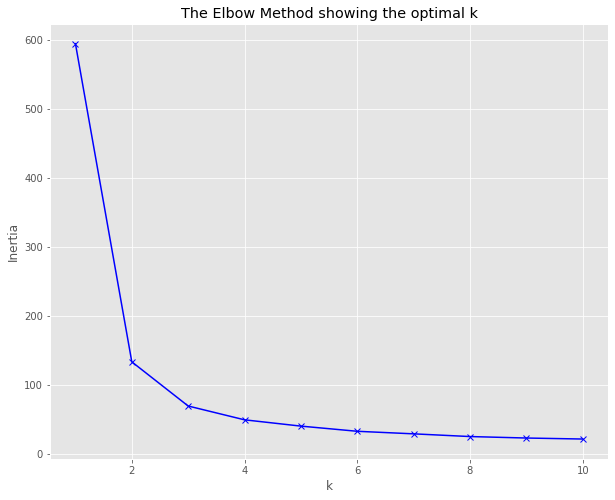

In [34]:
elbow_curve(iris_3D, maxClusters = 10)

En el gráfico se puede ver claramente que a partir de k = 3 ya no hay una mejoría significativa en la reducción de la variación intra-cluster (inercia), por lo tanto, según este método, la cantidad óptima de clusters para agrupar estos datos es tres.

### Estadístico de Gap

El objetivo de este método es definir un procedimiento estadístico para formalizar la heurística de la curva de codo. De forma muy simplificada, el estadístico de gap compara, para diferentes valores de k, la variación total intracluster observada frente al valor esperado acorde a una distribución uniforme de referencia (datos de referencia).

El valor a elegir será el k mas pequeño tal que en k+1 el gráfico caiga (no necesariamente es el máximo absoluto de la curva de gap).

In [35]:
# nrefs es la cantidad de datos ("datasets") de referencia contra los que se va a comparar
def optimalK(data, nrefs=3, maxClusters=15):

    gaps = np.zeros((len(range(1, maxClusters+1)),))
    resultsdf = pd.DataFrame({'clusterCount':[], 'gap':[]})
    for gap_index, k in enumerate(range(1, maxClusters+1)):

        # guardara los resultados de dispersión de cada distribución simulada
        refDisps = np.zeros(nrefs)

        # Genera las muestras aleatorias indicadas con nrefs y ejecuta k-means
        # en cada bucle obteniendo los resultados de dispersión (inercia)
        # para cada conjunto generado.
        for i in range(nrefs):
            
            # Crea nuevo conjunto aleatorio de referencia
            # Se puede usar una semilla para tener reproducibilidad
            np.random.seed(0)
            randomReference = np.random.random_sample(size=data.shape)
            
            # se ajusta el modelo al conjunto de referencia
            km = KMeans(k)
            km.fit(randomReference)
            # se guarda la dispersión obtenida
            refDisp = km.inertia_
            refDisps[i] = refDisp

        # Se ajusta el modelo a los datos originales y se guarda su inercia
        km = KMeans(k)
        km.fit(data)
        
        origDisp = km.inertia_

        # Calcula el estadístico de gap para k clusters usando el promedio de
        # las dispersiones de los datos simulados y la dispersión de los datos originales.
        gap = np.log(np.mean(refDisps)) - np.log(origDisp)

        # Guarda el estadístico de gap obtenido en este bucle.
        gaps[gap_index] = gap
        
        resultsdf = resultsdf.append({'clusterCount':k, 'gap':gap}, ignore_index=True)

    # Selecciona el "primer máximo" de los estadísticos obtenidos y devuelve 
    # su respectivo número de clusters    
    for i in range(0, len(gaps)-1):
      if gaps[i+1] <= gaps[i]:
        return (i+1, resultsdf)
    return (len(gaps), resultsdf)
    #return (gaps.argmax() + 1, resultsdf)  # Plus 1 because index of 0 means 1 cluster is optimal, index 2 = 3 clusters are optimal

In [36]:
k, gapdf = optimalK(iris_3D, nrefs=5, maxClusters=10)
print('La cantidad óptima de clusters es: ', k)

La cantidad óptima de clusters es:  4


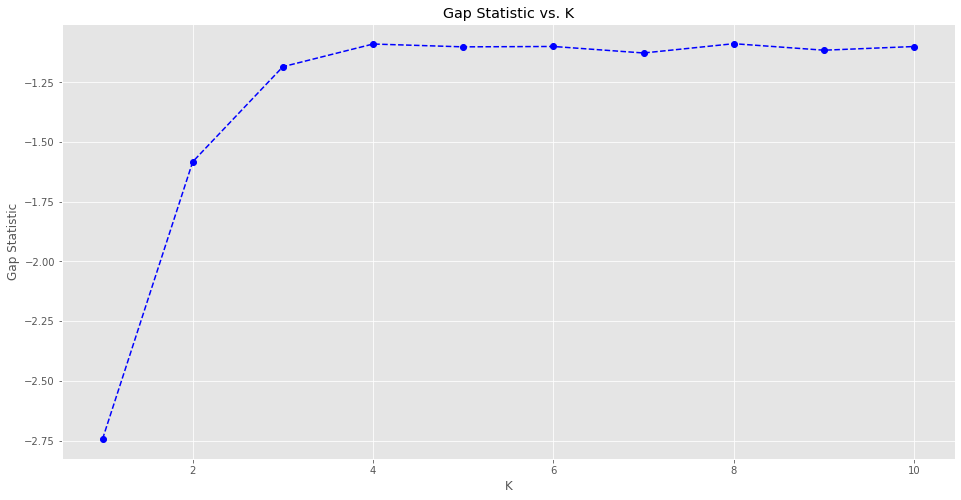

In [37]:
plt.figure(figsize=(16,8))
plt.plot(gapdf['clusterCount'], gapdf['gap'], linestyle='--', marker='o', color='b');
plt.xlabel('K');
plt.ylabel('Gap Statistic');
plt.title('Gap Statistic vs. K');

En el grafico se puede ver como en k = 5 el valor del estadístico de gap (que hasta ahora iba creciendo de forma constante) cae sutilmente respecto a su valor en k = 4; es por esto que se selecciona cuatro como la cantidad óptima de clusters, que no difiere mucho del resultado obtenido por el metodo del codo.

### Coeficiente de Silueta

Si le interesa saber como funciona este metodo puede consultar: [silhouette analysis on KMeans clustering](https://scikit-learn.org/stable/auto_examples/cluster/plot_kmeans_silhouette_analysis.html#sphx-glr-auto-examples-cluster-plot-kmeans-silhouette-analysis-py)

For n_clusters = 2 The average silhouette_score is : 0.684238805394747
For n_clusters = 3 The average silhouette_score is : 0.5496681486718052
For n_clusters = 4 The average silhouette_score is : 0.5080853407995718
For n_clusters = 5 The average silhouette_score is : 0.48756657645679763
For n_clusters = 6 The average silhouette_score is : 0.37327826715547996


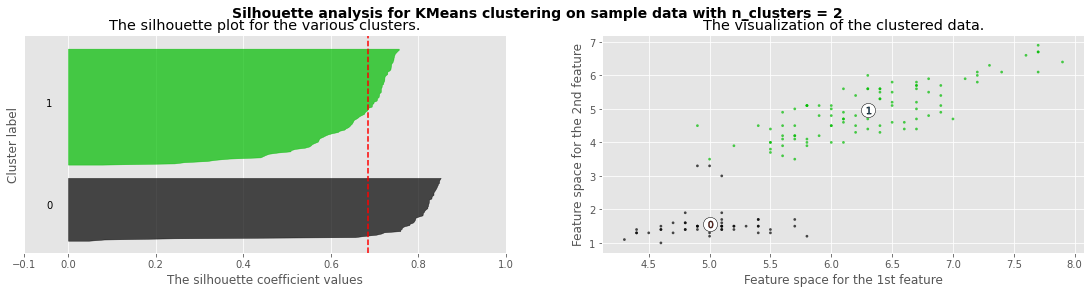

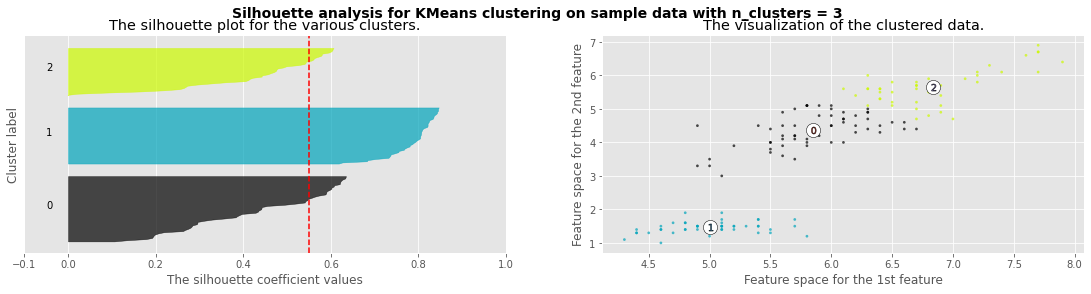

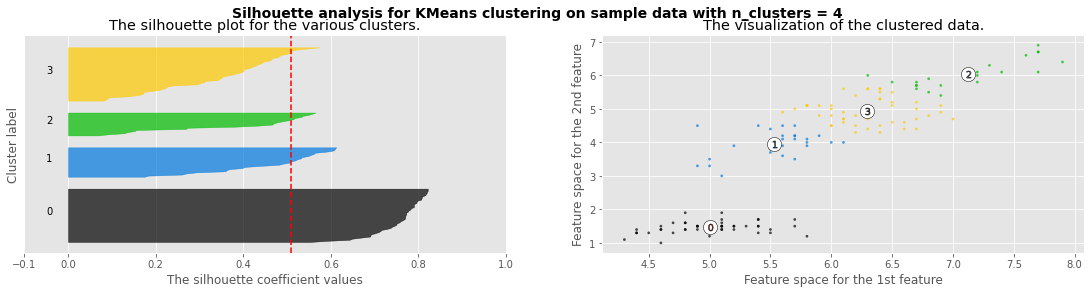

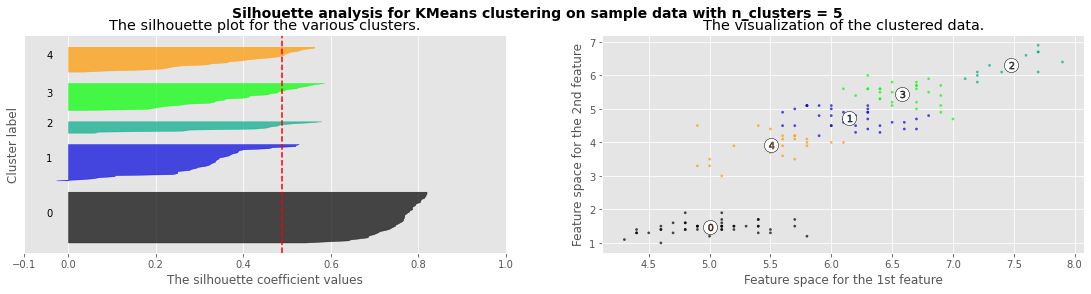

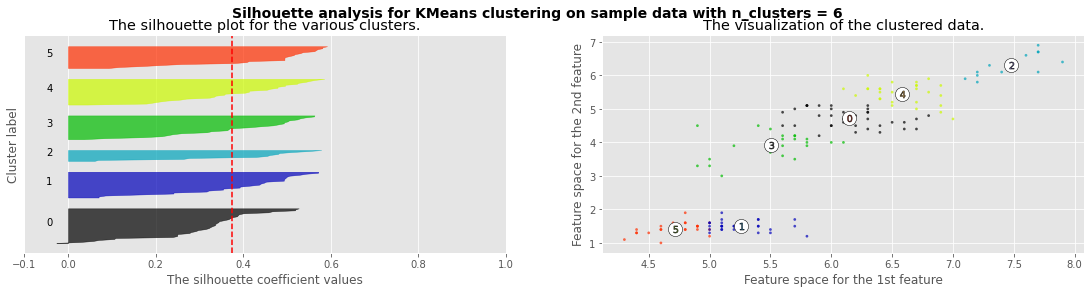

In [38]:
from sklearn.metrics import silhouette_samples, silhouette_score
import matplotlib.cm as cm

range_n_clusters = [2, 3, 4, 5, 6]
X = iris_3D

for n_clusters in range_n_clusters:
    # Create a subplot with 1 row and 2 columns
    fig, (ax1, ax2) = plt.subplots(1, 2)
    fig.set_size_inches(19, 4)

    # The 1st subplot is the silhouette plot
    # The silhouette coefficient can range from -1, 1 but in this example all
    # lie within [-0.1, 1]
    ax1.set_xlim([-0.1, 1])
    # The (n_clusters+1)*10 is for inserting blank space between silhouette
    # plots of individual clusters, to demarcate them clearly.
    ax1.set_ylim([0, len(X) + (n_clusters + 1) * 10])

    # Initialize the clusterer with n_clusters value and a random generator
    # seed of 10 for reproducibility.
    clusterer = KMeans(n_clusters=n_clusters, random_state=10)
    cluster_labels = clusterer.fit_predict(X)

    # The silhouette_score gives the average value for all the samples.
    # This gives a perspective into the density and separation of the formed
    # clusters
    silhouette_avg = silhouette_score(X, cluster_labels)
    print("For n_clusters =", n_clusters,
          "The average silhouette_score is :", silhouette_avg)

    # Compute the silhouette scores for each sample
    sample_silhouette_values = silhouette_samples(X, cluster_labels)

    y_lower = 10
    for i in range(n_clusters):
        # Aggregate the silhouette scores for samples belonging to
        # cluster i, and sort them
        ith_cluster_silhouette_values = \
            sample_silhouette_values[cluster_labels == i]

        ith_cluster_silhouette_values.sort()

        size_cluster_i = ith_cluster_silhouette_values.shape[0]
        y_upper = y_lower + size_cluster_i

        color = plt.cm.nipy_spectral(float(i) / n_clusters)
        ax1.fill_betweenx(np.arange(y_lower, y_upper),
                          0, ith_cluster_silhouette_values,
                          facecolor=color, edgecolor=color, alpha=0.7)

        # Label the silhouette plots with their cluster numbers at the middle
        ax1.text(-0.05, y_lower + 0.5 * size_cluster_i, str(i))

        # Compute the new y_lower for next plot
        y_lower = y_upper + 10  # 10 for the 0 samples

    ax1.set_title("The silhouette plot for the various clusters.")
    ax1.set_xlabel("The silhouette coefficient values")
    ax1.set_ylabel("Cluster label")

    # The vertical line for average silhouette score of all the values
    ax1.axvline(x=silhouette_avg, color="red", linestyle="--")

    ax1.set_yticks([])  # Clear the yaxis labels / ticks
    ax1.set_xticks([-0.1, 0, 0.2, 0.4, 0.6, 0.8, 1])

    # 2nd Plot showing the actual clusters formed
    colors = plt.cm.nipy_spectral(cluster_labels.astype(float) / n_clusters)
    ax2.scatter(X[:, 0], X[:, 1], marker='.', s=30, lw=0, alpha=0.7,
                c=colors, edgecolor='k')

    # Labeling the clusters
    centers = clusterer.cluster_centers_
    # Draw white circles at cluster centers
    ax2.scatter(centers[:, 0], centers[:, 1], marker='o',
                c="white", alpha=1, s=200, edgecolor='k')

    for i, c in enumerate(centers):
        ax2.scatter(c[0], c[1], marker='$%d$' % i, alpha=1,
                    s=50, edgecolor='k')

    ax2.set_title("The visualization of the clustered data.")
    ax2.set_xlabel("Feature space for the 1st feature")
    ax2.set_ylabel("Feature space for the 2nd feature")

    plt.suptitle(("Silhouette analysis for KMeans clustering on sample data "
                  "with n_clusters = %d" % n_clusters),
                 fontsize=14, fontweight='bold')

plt.show()

Podemos ver que los puntajes mas altos se obtuvieron para 2 y 3 clusters, pero se observa que los datos estan repartidos de forma mas equilibrada para k = 3, por lo tanto este sera el óptimo.

Entonces usamos k-means con k = 3.

In [39]:
kmeans_model_3D = KMeans(n_clusters=3, max_iter=1000).fit(iris_3D)
labels_3D = kmeans_model_3D.labels_
centroids_3D = kmeans_model_3D.cluster_centers_

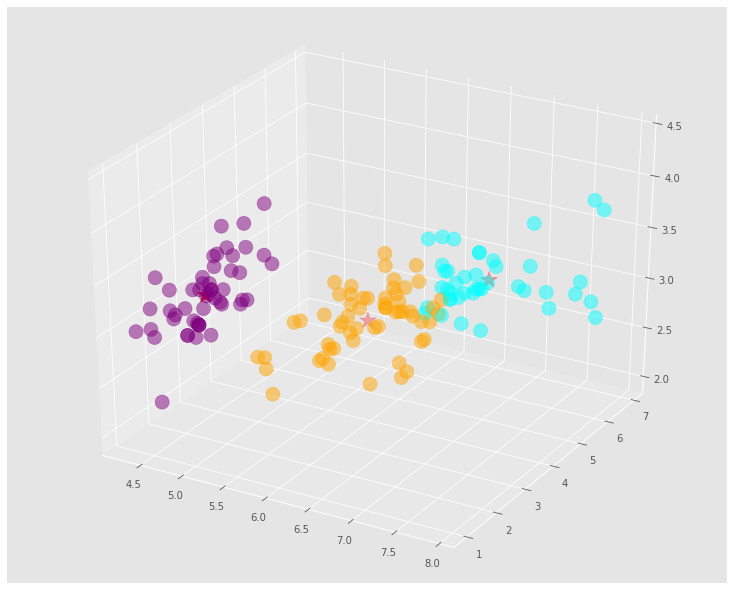

In [40]:
fig = plt.figure(figsize=(10, 8))
ax = Axes3D(fig)
ax.scatter(iris_3D[:, 0], iris_3D[:, 1], iris_3D[:, 2], c=labels_3D, s=200,
           cmap=matplotlib.colors.ListedColormap(colors_k_means), alpha=0.5)
ax.scatter(centroids_3D[:, 0], centroids_3D[:, 1], centroids_3D[:, 2], marker='*', c='r', s=300)
plt.show()

## Clustering usando las 4 características

Ahora vamos a usar toda la información disponible. Para ello primero separamos las etiquetas del resto de caracteristicas.

In [41]:
iris_features = iris_df.drop('class', axis=1)
iris_features.head()

,sepal-length,sepal-width,petal-length,petal-width
0,6.5,2.8,4.6,1.5
1,6.4,2.8,5.6,2.1
2,4.3,3.0,1.1,0.1
3,5.7,2.9,4.2,1.3
4,6.0,2.9,4.5,1.5


Ajustamos un nuevo modelo usando las cuatro caracteristicas.

In [42]:
kmeans_model = KMeans(n_clusters=3).fit(iris_features)

Vemos las etiquetas asignadas a los puntos.

In [43]:
iris_4F_labels = kmeans_model.labels_
print(iris_4F_labels)

[2 0 1 2 2 2 2 1 1 1 2 1 2 2 2 1 0 1 1 1 0 2 2 2 2 0 2 0 0 0 2 1 2 2 0 0 1
 0 2 1 1 0 2 2 1 0 2 1 1 2 1 0 1 2 2 1 2 2 2 2 2 1 0 2 0 1 2 1 0 1 1 2 2 1
 2 1 0 0 1 0 1 2 1 0 2 1 2 1 0 2 0 0 0 0 2 2 2 1 1 0 1 2 0 0 1 0 2 0 0 1 1
 1 2 0 0 0 2 1 0 2 1 2 0 2 1 2 1 2 2 1 1 2 1 2 2 1 2 2 0 1 2 2 1 2 1 1 0 2
 2 2]


Ahora podemos ver los vectores de los centroides.

In [44]:
centroides_4F = kmeans_model.cluster_centers_
print(centroides_4F)

[[6.85       3.07368421 5.74210526 2.07105263]
 [5.006      3.418      1.464      0.244     ]
 [5.9016129  2.7483871  4.39354839 1.43387097]]


Añadimos las etiquetas obtenidas al conjunto de datos.

In [45]:
iris_features['cluster'] = iris_4F_labels
iris_features.sample(5)

,sepal-length,sepal-width,petal-length,petal-width,cluster
48,4.6,3.6,1.0,0.2,1
13,6.7,3.1,4.7,1.5,2
40,5.5,4.2,1.4,0.2,1
44,5.0,3.4,1.6,0.4,1
51,7.3,2.9,6.3,1.8,0


In [46]:
cluster_0 = iris_features[iris_features['cluster'] == 0]
cluster_0.drop('cluster', axis=1).describe()

,sepal-length,sepal-width,petal-length,petal-width
count,38.000000,38.000000,38.000000,38.000000
mean,6.850000,3.073684,5.742105,2.071053
std,0.494155,0.290092,0.488590,0.279872
min,6.100000,2.500000,4.900000,1.400000
25%,6.425000,2.925000,5.425000,1.825000
50%,6.700000,3.000000,5.650000,2.100000
75%,7.200000,3.200000,6.000000,2.300000
max,7.900000,3.800000,6.900000,2.500000


In [47]:
cluster_1 = iris_features[iris_features['cluster'] == 1]
cluster_1.drop('cluster', axis=1).describe()

,sepal-length,sepal-width,petal-length,petal-width
count,50.00000,50.000000,50.000000,50.00000
mean,5.00600,3.418000,1.464000,0.24400
std,0.35249,0.381024,0.173511,0.10721
min,4.30000,2.300000,1.000000,0.10000
25%,4.80000,3.125000,1.400000,0.20000
50%,5.00000,3.400000,1.500000,0.20000
75%,5.20000,3.675000,1.575000,0.30000
max,5.80000,4.400000,1.900000,0.60000


In [48]:
cluster_2 = iris_features[iris_features['cluster'] == 2]
cluster_2.drop('cluster', axis=1).describe()

,sepal-length,sepal-width,petal-length,petal-width
count,62.000000,62.000000,62.000000,62.000000
mean,5.901613,2.748387,4.393548,1.433871
std,0.466410,0.296284,0.508895,0.297500
min,4.900000,2.000000,3.000000,1.000000
25%,5.600000,2.500000,4.025000,1.300000
50%,5.900000,2.800000,4.500000,1.400000
75%,6.200000,3.000000,4.800000,1.575000
max,7.000000,3.400000,5.100000,2.400000


Originalmente se tenian 50 obsevaciones de cada especie; ahora analizando los clusters obtenidos después de aplicar k-means vemos que el cluster_0 queda con 50 observaciones, el cluster_1 con 62 y el cluster_2 con 38. De aquí podemos inferir que algunas especies fueron mal clasificadas como era de esperarse, pero son pocas comparado con el total de datos.

### Observaciones más cercanas a cada centroide.

Con las características podemos encontrar la observación mas representativa de cada cluster para así caracterizar las demás observaciones dentro del cluster.

Obtenemos la observación más cercana a cada centroide haciendo uso de `pairwise_distances_argmin_min` que devuelve el indice de dichas observaciones.

In [ ]:
closest, _ = pairwise_distances_argmin_min(centroides_4F, iris_features.drop('cluster', axis=1))
closest

Observación más cercana al centroide del cluster 0

In [ ]:
print(tabulate(iris_features.iloc[[7]], headers = 'keys', tablefmt = 'orgtbl'))

Observación más cercana al centroide del cluster 1

In [ ]:
print(tabulate(iris_features.iloc[[78]], headers = 'keys', tablefmt = 'orgtbl'))

Observación más cercana al centroide del cluster 2

In [ ]:
print(tabulate(iris_features.iloc[[112]], headers = 'keys', tablefmt = 'orgtbl'))

### Características representativas de las especies de flores iris

En promedio, las observaciones del cluster_0 tienen las siguientes características que las representan:

* sepal-length = 5.0 cm
* sepal-width	= 3.4 cm
* petal-length	= 1.5 cm
* petal-width = 0.2 cm

Se pueden verificar estos datos para los demás clusters.

### Predicción para nueva observación

Suponiendo que encontramos una nueva flor (independiente de los datos que teniamos) con las siguientes características:

sepal-length = 6.22,  sepal-width = 4.3,  petal-length = 1.4, petal-width = 0.4.

Nos gustaría saber dentro de cuál grupo se podria clasificar.

In [ ]:
# Con el modelo entrenado puedo hacer predicciones para
# observaciones nuevas
X_new = np.array([["Aqui van los valores de las caracteristicas separados por comas"]]) #nueva observación
 
new_labels = kmeans_model.predict(X_new)
print(new_labels)